## Set up the environment

In [2]:
import argparse
import glob
import os

import torch
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

from hidt.networks.enhancement.RRDBNet_arch import RRDBNet
from hidt.style_transformer import StyleTransformer
from hidt.utils.preprocessing import GridCrop, enhancement_preprocessing


## Load images, initialise generator network
Set up networks for the conversion

In [3]:
config_path = '../configs/daytime.yaml'
gen_weights_path = '../trained_models/generator/daytime.pt'
inference_size = 256  # the network has been trained to do inference in 256px, any higher value might lead to artifacts
device = 'cuda:0'
image_path = '../images/daytime/content/1.jpg'
styles_path = '../styles.txt'
enhancer_weights = '../trained_models/enhancer/enhancer.pth'

style_transformer = StyleTransformer(config_path,
                                     gen_weights_path,
                                     inference_size=inference_size,
                                     device=device)
with open(styles_path) as f:
    styles = f.read()
styles = {style.split(',')[0]: torch.tensor([float(el) for el in style.split(',')[1][1:-1].split(' ')]) for style in styles.split('\n')[:-1]}
image = Image.open(image_path)
crop_transform = GridCrop(4, 1, hires_size=inference_size * 4)

## Original image

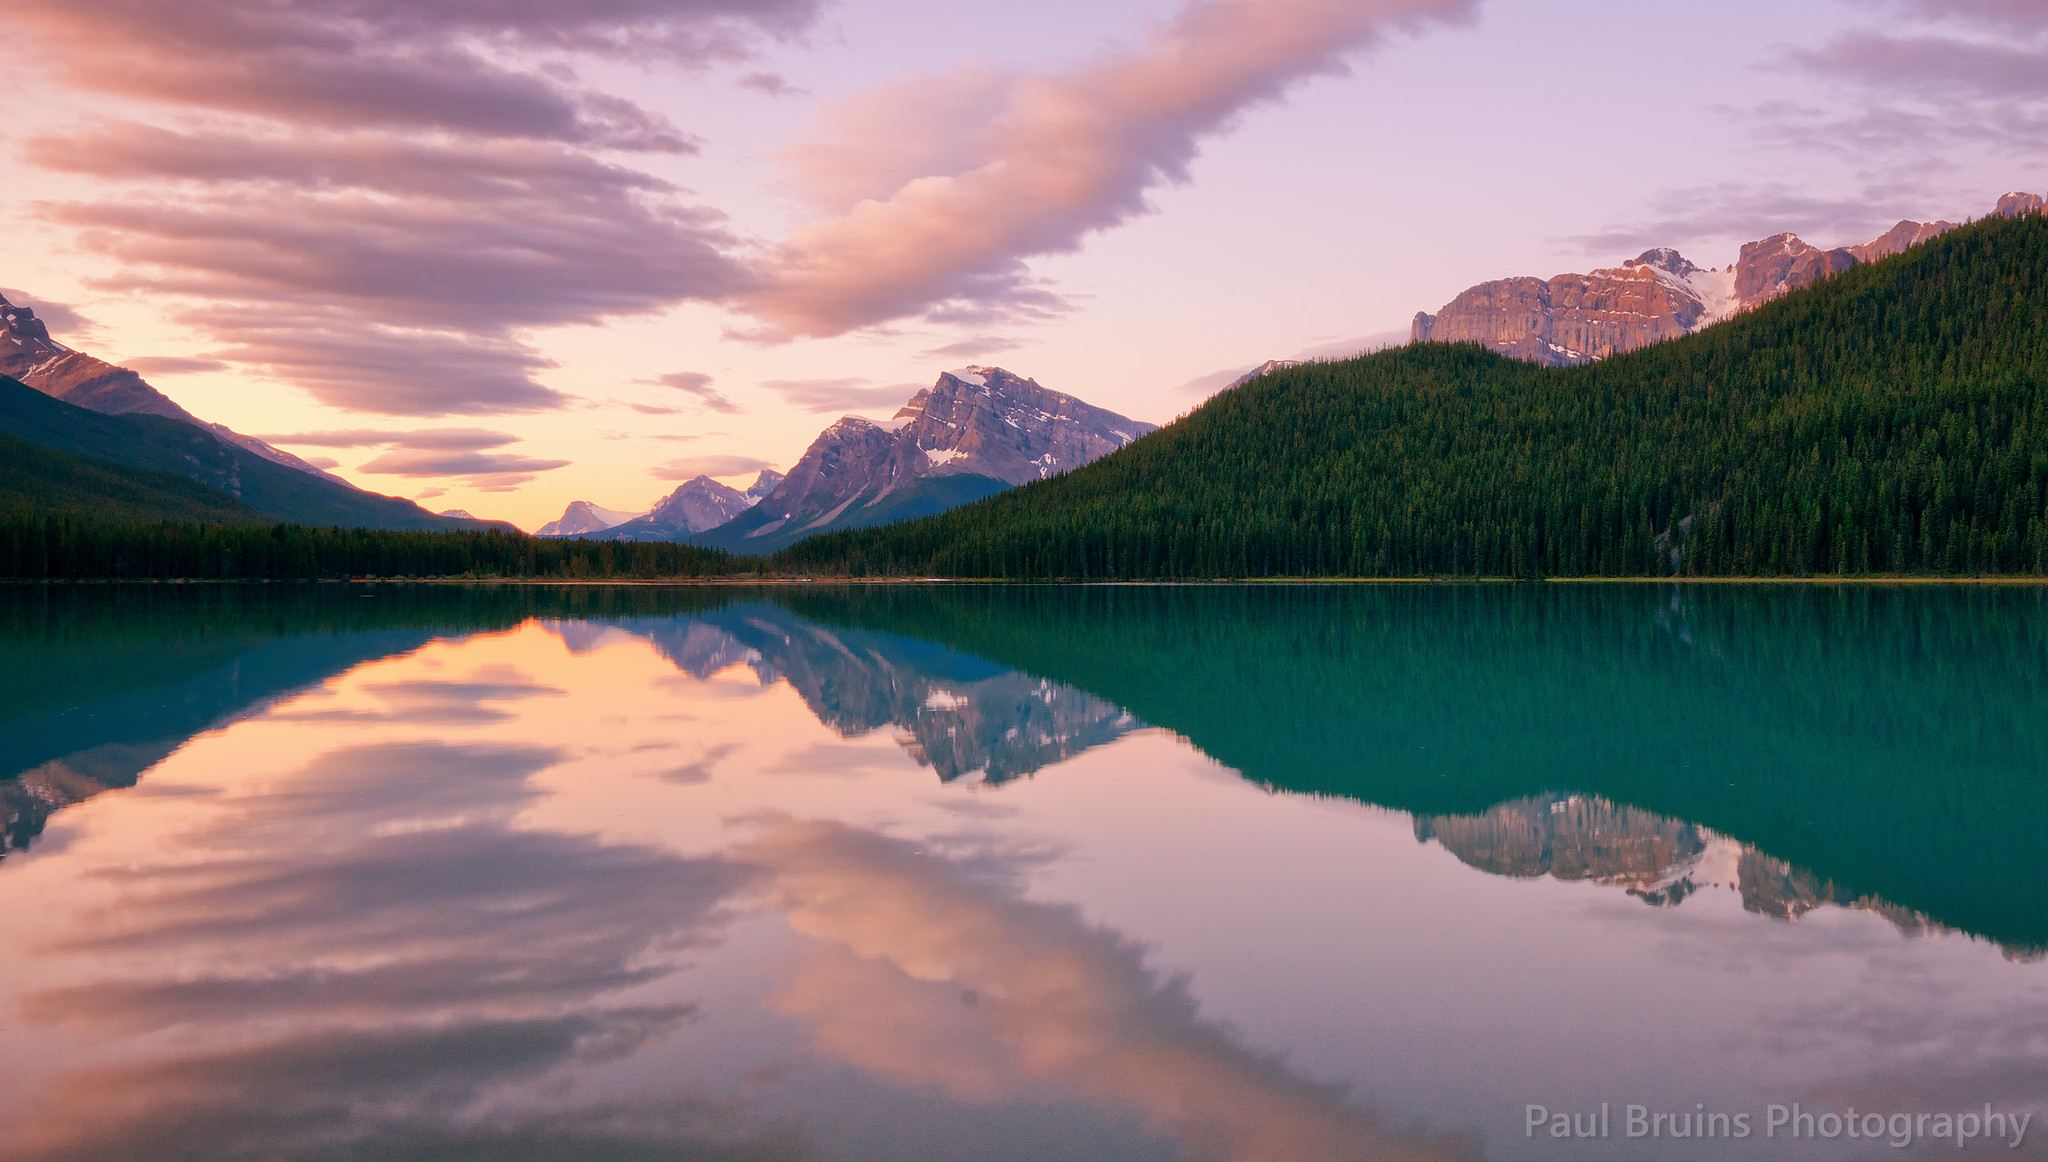

In [4]:
image

## Choose style vector you want to transfer to
We have provided styles.txt file with eight styles that we found nice and meaningfull
You can find the full list of styles below

In [5]:
print(list(styles.keys()))

['hard_day', 'semihard_day', 'day', 'presunset', 'sunset_hard_harder', '5minute', 'bluehour_hard', 'night']


In [6]:
# Select the style, or define any vector you want
style_to_transfer = styles['sunset_hard_harder']

## Do forward pass through the generator

In [7]:
style_to_transfer = style_to_transfer.view(1, 1, 3, 1).to(device)
with torch.no_grad():
    content_decomposition = style_transformer.get_content(image)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']

## Single-image transfer
This is the lowres transfer (smaller size scaled to the inference_size resolution)

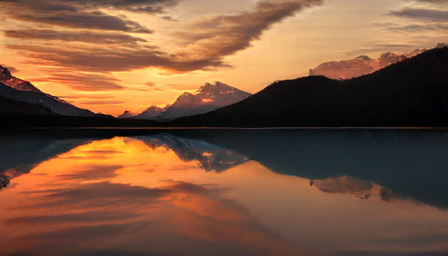

In [8]:
transforms.ToPILImage()((transferred[0].cpu().clamp(-1, 1) + 1.) / 2.)

## Let's apply the enhancement network to obtain 4x upscaled image

In [9]:
enhancer = RRDBNet(in_nc=48, out_nc=3, nf=64, nb=5, gc=32).to(device)
enhancer.load_state_dict(torch.load(enhancer_weights))
with torch.no_grad():
    crops = [img for img in crop_transform(image)]
    content_decomposition = style_transformer.get_content(crops)[0]
    decoder_input = {'content': content_decomposition['content'],
                     'intermediate_outputs': content_decomposition['intermediate_outputs'],
                     'style': style_to_transfer.repeat(16, 1, 1, 1)}
    transferred = style_transformer.trainer.gen.decode(decoder_input)['images']
    padded_stack = enhancement_preprocessing(transferred, normalize=False)
    out = enhancer(padded_stack)


## Final result

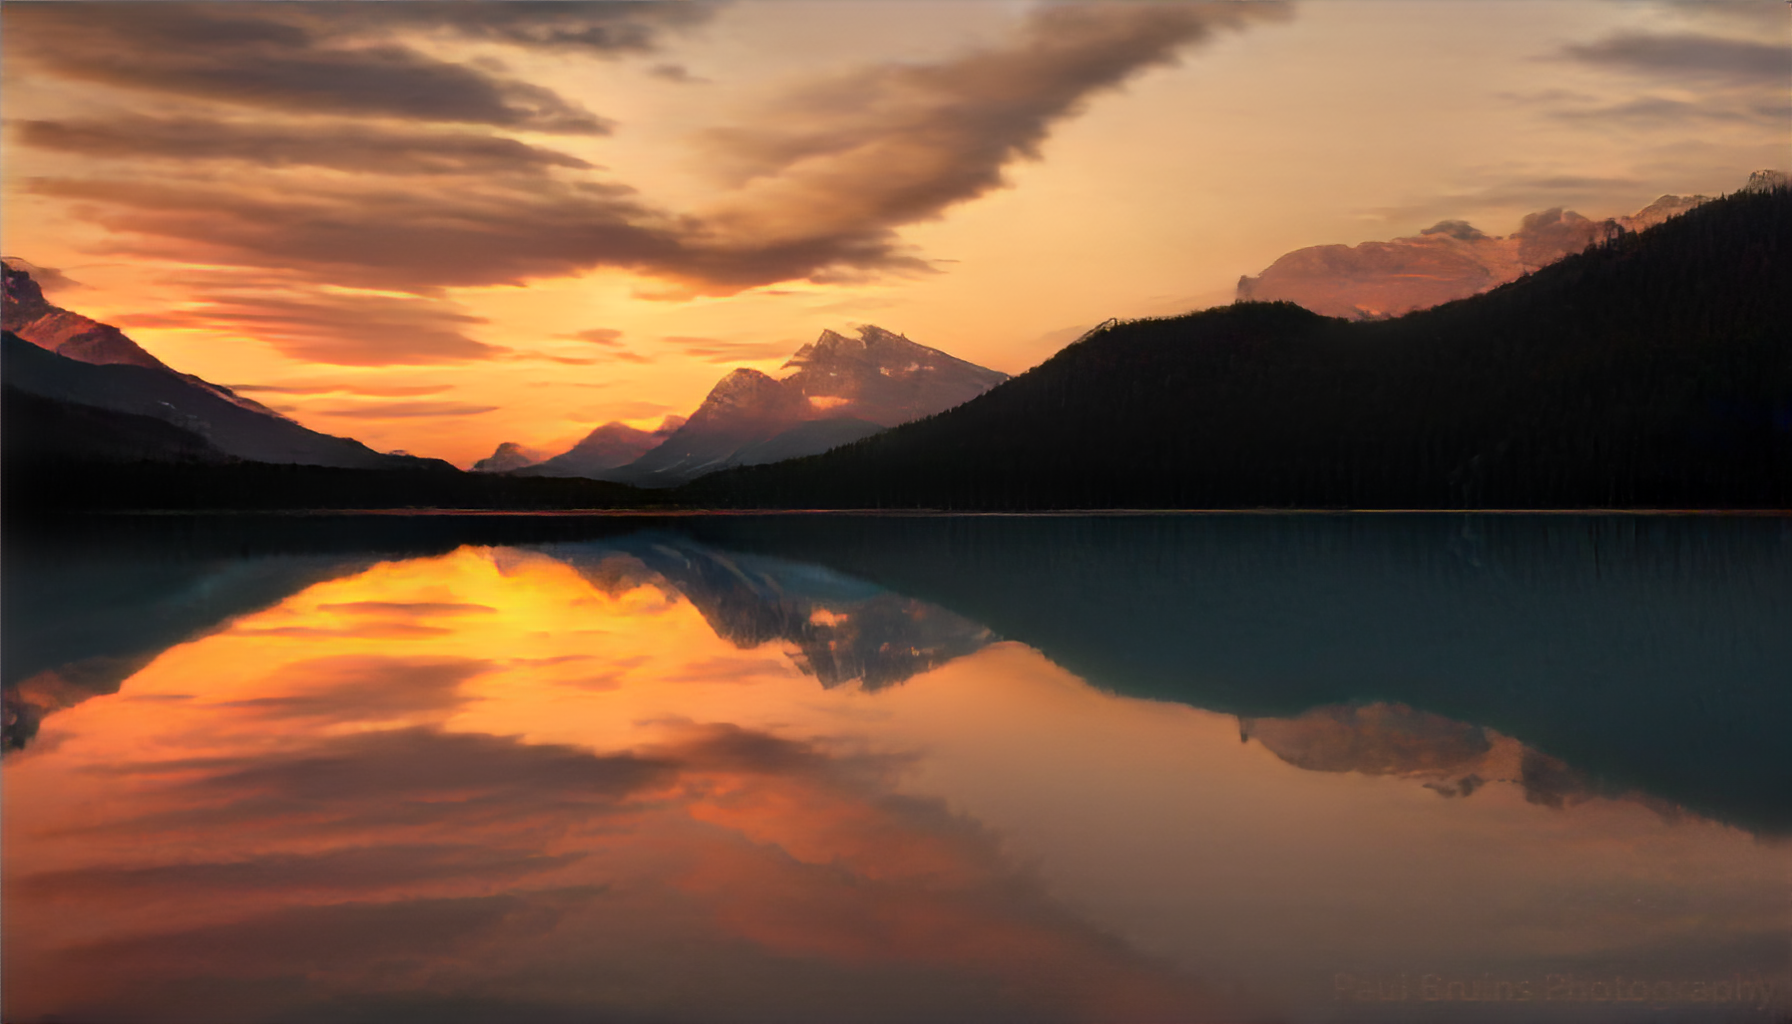

In [10]:
transforms.ToPILImage()((out.cpu()[0].clamp(-1, 1) + 1.) / 2.)